# Backtesting

This notebook generates plots for the backtesting. It requires that the script `run_backtesting.sh` has been run prior to execution.

In [1]:
#%load_ext autoreload
#%autoreload 2

In [2]:
import datetime
import math
import os
import pickle
import re
import logging
from collections import Counter, OrderedDict, defaultdict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import torch
import pyro.distributions as dist
from pyrocov import mutrans, pangolin, stats
from pyrocov.stats import normal_log10bf
from pyrocov.util import pretty_print, pearson_correlation
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np

In [3]:
matplotlib.rcParams["figure.dpi"] = 200

In [4]:
# configure logging
logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)
# This line can be used to modify logging as required later in the notebook
#logging.getLogger().setLevel(logging.INFO)

In [5]:
# set matplotlib params
#matplotlib.rcParams["figure.dpi"] = 200
#matplotlib.rcParams['figure.figsize'] = [8, 8]
matplotlib.rcParams["axes.edgecolor"] = "gray"
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Avenir', 'DejaVu Sans']

## Load input data

In [6]:
# Load the entire constant dataset
max_num_clades = 5000
min_num_mutations = 1
min_region_size = 50
ambiguous = False
columns_filename=f"results/columns.{max_num_clades}.pkl"
features_filename=f"results/features.{max_num_clades}.{min_num_mutations}.pt"

In [7]:
input_dataset = mutrans.load_gisaid_data(
        device="cpu",
        columns_filename=columns_filename,
        features_filename=features_filename,
        min_region_size=min_region_size,
        ambiguous=ambiguous,
)

    15792 Loading data
    21087 Training on 4836426 rows with columns:
    21088 clade, clades, lineage, lineages, virus_name, accession_id, collection_date, location, add_location, day
    29451 Loaded 5000 x 4120 feature matrix
    48377 WARNING skipped 0 unsampled clades
    48381 Found 1189 states in 204 countries
    51263 Dataset size [T x P x C] 52 x 1393 x 5000
    51263 Keeping 4836426/4836426 rows (dropped 0)


In [8]:
input_dataset.keys()

dict_keys(['ancestry', 'clade_id', 'clade_id_inv', 'clade_id_to_lineage_id', 'clade_to_lineage', 'features', 'lineage_id', 'lineage_id_inv', 'lineage_id_to_clade_id', 'lineage_to_clade', 'location_id', 'location_id_inv', 'mutations', 'pc_index', 'sparse_counts', 'sparse_hist', 'state_to_country', 'time', 'weekly_clades'])

In [9]:
input_dataset['clade_id_to_lineage_id']

tensor([   0,    5,   31,  ..., 1318, 1326, 1317])

In [10]:
len(input_dataset['clade_id_to_lineage_id'])

5000

In [11]:
len(np.unique(input_dataset['clade_id_to_lineage_id'].numpy()))

1502

## Load trained models

In [12]:
fits = torch.load("results/mutrans.backtesting.pt", map_location="cpu")

In [13]:
print(f'We have loaded {len(fits)} models')

We have loaded 29 models


In [14]:
# print info on available models and what the keys are
if True:
    for key in fits:
        print(key)
    first_key = list(fits.keys())[0]
    fits[first_key].keys()

('coef_scale=0.05', 'reparam', 'full', 10001, 0.05, 0.1, 10.0, 200, 12, 150, ())
('coef_scale=0.05', 'reparam', 'full', 10001, 0.05, 0.1, 10.0, 200, 12, 164, ())
('coef_scale=0.05', 'reparam', 'full', 10001, 0.05, 0.1, 10.0, 200, 12, 178, ())
('coef_scale=0.05', 'reparam', 'full', 10001, 0.05, 0.1, 10.0, 200, 12, 192, ())
('coef_scale=0.05', 'reparam', 'full', 10001, 0.05, 0.1, 10.0, 200, 12, 206, ())
('coef_scale=0.05', 'reparam', 'full', 10001, 0.05, 0.1, 10.0, 200, 12, 220, ())
('coef_scale=0.05', 'reparam', 'full', 10001, 0.05, 0.1, 10.0, 200, 12, 234, ())
('coef_scale=0.05', 'reparam', 'full', 10001, 0.05, 0.1, 10.0, 200, 12, 248, ())
('coef_scale=0.05', 'reparam', 'full', 10001, 0.05, 0.1, 10.0, 200, 12, 262, ())
('coef_scale=0.05', 'reparam', 'full', 10001, 0.05, 0.1, 10.0, 200, 12, 276, ())
('coef_scale=0.05', 'reparam', 'full', 10001, 0.05, 0.1, 10.0, 200, 12, 290, ())
('coef_scale=0.05', 'reparam', 'full', 10001, 0.05, 0.1, 10.0, 200, 12, 304, ())
('coef_scale=0.05', 'reparam

In [15]:
# Print the shape of the weekly strains in each fit
print('The weekly clades')
for fit in fits.values():
    print(fit["weekly_clades_shape"])

The weekly clades
(11, 844, 5000)
(12, 865, 5000)
(13, 887, 5000)
(14, 912, 5000)
(15, 923, 5000)
(16, 946, 5000)
(17, 956, 5000)
(18, 986, 5000)
(19, 993, 5000)
(20, 1000, 5000)
(21, 1014, 5000)
(22, 1021, 5000)
(23, 1043, 5000)
(24, 1056, 5000)
(25, 1074, 5000)
(26, 1084, 5000)
(27, 1102, 5000)
(28, 1123, 5000)
(29, 1162, 5000)
(30, 1200, 5000)
(31, 1229, 5000)
(32, 1252, 5000)
(33, 1282, 5000)
(34, 1301, 5000)
(35, 1313, 5000)
(36, 1317, 5000)
(37, 1326, 5000)
(38, 1333, 5000)
(39, 1336, 5000)


Scale `coef` by 1/100 in all results.

In [16]:
ALREADY_SCALED = set()

def scale_tensors(x, names={"coef"}, scale=0.01, prefix="", verbose=True):
    if id(x) in ALREADY_SCALED:
        return
    if isinstance(x, dict):
        for k, v in list(x.items()):
            if k in names:
                if verbose:
                    print(f"{prefix}.{k}")
                x[k] = v * scale
            elif k == "diagnostics":
                continue
            else:
                scale_tensors(v, names, scale, f"{prefix}.{k}", verbose=verbose)
    ALREADY_SCALED.add(id(x))
                
scale_tensors(fits, verbose=False)

# Forecasting

In [17]:
fit0 = fits[list(fits.keys())[0]]
fit0.keys()

dict_keys(['median', 'mean', 'std', 'losses', 'series', 'params', 'walltime', 'args', 'mutations', 'weekly_clades', 'weekly_cases', 'weekly_clades_shape', 'location_id', 'clade_id_inv', 'location_id_inv', 'lineage_id_inv'])

In [18]:
fit_n = fits[list(fits.keys())[25]]
fit_n.keys()

dict_keys(['median', 'mean', 'std', 'losses', 'series', 'params', 'walltime', 'args', 'mutations', 'weekly_clades', 'weekly_cases', 'weekly_clades_shape', 'location_id', 'clade_id_inv', 'location_id_inv', 'lineage_id_inv'])

In [19]:
fit0['mean']['probs'].shape # T, P, C

torch.Size([23, 844, 1502])

In [20]:
fit0['weekly_cases'].shape

torch.Size([11, 844])

In [21]:
def weekly_clades_to_lineages(weekly_clades, clade_id_to_lineage_id, n_model_lineages):
    weekly_lineages = weekly_clades.new_zeros(weekly_clades.shape[:-1] + (n_model_lineages,)).scatter_add_(
        -1, clade_id_to_lineage_id.expand_as(weekly_clades), weekly_clades)
    return weekly_lineages

In [22]:
def plusminus(mean, std):
    p95 = 1.96 * std
    return torch.stack([mean - p95, mean, mean + p95])

In [23]:
from pyrocov.util import (
    pretty_print, pearson_correlation, quotient_central_moments, generate_colors
)

In [24]:
input_dataset.keys()

dict_keys(['ancestry', 'clade_id', 'clade_id_inv', 'clade_id_to_lineage_id', 'clade_to_lineage', 'features', 'lineage_id', 'lineage_id_inv', 'lineage_id_to_clade_id', 'lineage_to_clade', 'location_id', 'location_id_inv', 'mutations', 'pc_index', 'sparse_counts', 'sparse_hist', 'state_to_country', 'time', 'weekly_clades'])

In [44]:
def plot_forecast2(fit, input_dataset, queries, num_strains=10, filenames=[], verbose=False):
    # Convert queries to array if only only string
    if isinstance(queries, str):
        queries = [queries]
    
    # Get dimensions of the model fit (T,P,L) these are probabilities
    n_model_periods, n_model_places, n_model_lineages = fit['mean']['probs'].shape
    if (verbose):
        print('---')
        print(f'n_model_periods: {n_model_periods}')
        print(f'n_model_places: {n_model_places}')
        print(f'n_model_lineages: {n_model_lineages}')
    
    # Get dimensions of weekly_cases (T,P) these are JHU counts
    weekly_cases_fit = fit['weekly_cases']
    n_cases_periods, n_cases_places = weekly_cases_fit.shape
    if (verbose):
        print('---')
        print(f'n_cases_periods: {n_cases_periods}')
        print(f'n_cases_places: {n_cases_places}')
    
    # Some checks
    assert n_cases_places == n_model_places
    assert n_model_periods > n_cases_periods
    
    # Calculate how many periods are forecasted (i.e. are beyond the input to the model)
    n_forecast_steps = n_model_periods - n_cases_periods
    if (verbose):
        print(f'n_forecast_steps: {n_forecast_steps}')
        
    # Weekly case counts by time place and clade obtained from the fit
    weekly_clades_fit = fit['weekly_clades'] # T, P, C
    if verbose:
        print('---')
        print(f'weekly_clades_fit shape: {weekly_clades_fit.shape}')
    
    # Weekly case counts by time place and clade obtain from the input data
    # This has more time point and more regions than the one from the fit
    weekly_clades_data = input_dataset['weekly_clades']
    if verbose:
        print('---')
        print(f'weekly_clades_data shape: {weekly_clades_data.shape}')
    
    # Mapping from clades to lineages, a tensor of indexes
    # This is valid for both the fit and the input_data
    clade_id_to_lineage_id = input_dataset['clade_id_to_lineage_id']
    if verbose:
        print('---')
        print(f'clade_id_to_lineage_id length: {len(clade_id_to_lineage_id)}')
    
    # Summarize the counts of the weekly_clades (from data or fit) to the number of lineages in the model
    weekly_lineages_data = weekly_clades_to_lineages(weekly_clades_data, clade_id_to_lineage_id, n_model_lineages)
    weekly_lineages_fit = weekly_clades_to_lineages(weekly_clades_fit, clade_id_to_lineage_id, n_model_lineages)
    
    # Add CI to the probs
    probs = plusminus(fit['mean']['probs'], fit['std']['probs']) # [3,T,P,L]
    
    # Expand weekly_cases_fit (JHU counts) from the model to cover the steps we are forecasting
    padding = 1 + weekly_cases_fit.mean(0, keepdim=True).expand(n_forecast_steps, -1)
    weekly_cases_fit_ = torch.cat([weekly_cases_fit, padding], 0)
    # Generate predictions
    # Note: For the evaluation maybe we are better off comparing probabilities not counts
    predicted = probs * weekly_cases_fit_[..., None]
    
    # This is an array of strings listing the locations for the data
    location_id_inv_data = input_dataset['location_id_inv']
    if (verbose):
        print('---')
        print(f'location_id_inv_data length: {len(location_id_inv_data)}')
    
    # This is an array of strings listing the locations for the fit
    location_id_inv_fit = fit['location_id_inv']
    if verbose:
        print('---')
        print(f'location_id_inv_fit length: {len(location_id_inv_fit)}')
    
    # Get the location indexes that we want to keep based on query for the data
    ids_fit = torch.tensor([i for i, name in enumerate(location_id_inv_fit) if any(q in name for q in queries)])
    
    # Subset weekly_lineages_fit to those location sum over time and place and get the indices in descending order
    strain_ids_fit = weekly_lineages_fit[:, ids_fit].sum([0, 1]).sort(-1, descending=True).indices
    if verbose:
        print('---')
        print(f'strain_ids_fit shape: {strain_ids_fit.shape}')
    # Keep only the top n number of strains we want to plot
    strain_ids_fit = strain_ids_fit[:num_strains]
    
    # Same thing for the data
    ids_data = torch.tensor([ i for i, name in enumerate(location_id_inv_data) if any(q in name for q in queries)])
    strain_ids_data = weekly_lineages_data[:, ids_data].sum([0, 1]).sort(-1, descending=True).indices
    
    # Not sure what this is, but we need it!
    lineage_id_inv_fit = fit['lineage_id_inv']
    lineage_id_inv_data = input_dataset['lineage_id_inv']
    
    # Get some colors to plot with
    colors = generate_colors()
    assert len(colors) >= num_strains
    light = '#bbbbbb'
    
    dark = '#444444'
    
    # Generate Figure
    fig, axes = plt.subplots(len(queries), figsize=(8, 0.5 + 2.5 * len(queries)), sharex=True)
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    
    # Get x axis dates for plotting
    dates = matplotlib.dates.date2num(mutrans.date_range(len(fit["mean"]["probs"])))

    
    # Query (region) plotting loop
    for row, (query, ax) in enumerate(zip(queries, axes)):
        # location ids for this query (some queries are made of multiple regions)
        ids_fit = torch.tensor([i for i, name in enumerate(location_id_inv_fit) if query in name])
        print(f"{query} matched {len(ids_fit)} regions in the fit")
        
        # location ids for this query in the data
        ids_data = torch.tensor([i for i, name in enumerate(location_id_inv_data) if query in name])
        
        if len(axes) > 1:
            # Plot weekly cases total
            counts = weekly_cases_fit[:, ids_fit].sum(1)
            if verbose:
                print(f"{query}: max {counts.max():g}, total {counts.sum():g}")
            counts /= counts.max()
            ax.plot(dates[:len(counts)], counts, "k-", color=light, lw=0.8, zorder=-20)
            
            # Plot weekly lineages total we are getting the data from the fit not the dataset
            counts = weekly_lineages_fit[:, ids_fit].sum([1, 2])
            counts /= counts.max()
            ax.plot(dates[:len(counts)], counts, "k--", color=light, lw=1, zorder=-20)
            
            
        # Get the predictions for the relevant regions, normalize
        pred = predicted.index_select(-2, ids_fit).sum(-2)
        pred /= pred[1].sum(-1, True).clamp_(min=1e-20)
        
        # Get the observations for the relevant regions
        obs = weekly_lineages_fit[:, ids_fit].sum(1)
        obs /= obs.sum(-1, True).clamp_(min=1e-9)
        
        obs_data = weekly_lineages_data[:, ids_data].sum(1)
        obs_data /= obs_data.sum(-1, True).clamp(min=1e-9)
        
        # Strain plotting loop
        for s, color in zip(strain_ids_fit, colors):
            lb, mean, ub = pred[..., s]
            ax.fill_between(dates, lb, ub, color=color, alpha=0.2, zorder=-10)
            ax.plot(dates, mean, color=color, lw=1, zorder=-9)
            lineage = lineage_id_inv_fit[s]
            ax.plot(dates[:len(obs)], obs[:, s], color=color, lw=0, marker='o', markersize=3,
                    label=lineage if row == 0 else None)
        
        # Plot observations from the dataset for all the forecast points
        # TODO: Fix colors to match ( just need to reorder the strain_ids_data )
        for s, color in zip(strain_ids_data, colors):
            lineage = lineage_id_inv_data[s]
            ax.plot(dates[len(obs):(len(obs)+n_forecast_steps)], obs_data[len(obs):len(obs)+n_forecast_steps, s], 
                    color=color, lw=0, marker='x', markersize=2,
                        label=lineage if row == 0 else None)
        
        # Set axis ticks
        ax.set_ylim(0, 1)
        ax.set_yticks(())
        ax.set_ylabel(query.replace(" / ", "\n"))
        ax.set_xlim(dates.min(), dates.max())
        
        # Print legend
        if row == 0:
            ax.legend(loc="upper left", fontsize=8 * (10 / num_strains) ** 0.8)
        elif row == 1:
            ax.plot([], "k--", color=light, lw=1, label="relative #samples")
            ax.plot([], "k-", color=light, lw=0.8, label="relative #cases")
            ax.plot([], lw=0, marker='o', markersize=3, color='gray',
                    label="observed portion")
            ax.fill_between([], [], [], color='gray', label="predicted portion")
            ax.legend(loc="upper left",)
          
    # Setup the date axis correctly
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b %Y"))
    plt.xticks(rotation=90)
    plt.subplots_adjust(hspace=0)

---
n_model_periods: 48
n_model_places: 1317
n_model_lineages: 1502
---
n_cases_periods: 36
n_cases_places: 1317
n_forecast_steps: 12
---
weekly_clades_fit shape: torch.Size([36, 1317, 5000])
---
weekly_clades_data shape: torch.Size([52, 1393, 5000])
---
clade_id_to_lineage_id length: 5000
---
location_id_inv_data length: 1393
---
location_id_inv_fit length: 1317
---
strain_ids_fit shape: torch.Size([1502])
England matched 1 regions in the fit
England: max 48048, total 360597
USA / Massachusetts matched 1 regions in the fit
USA / Massachusetts: max 495, total 1819
Brazil matched 28 regions in the fit
Brazil: max 2.42686e+06, total 2.56184e+07


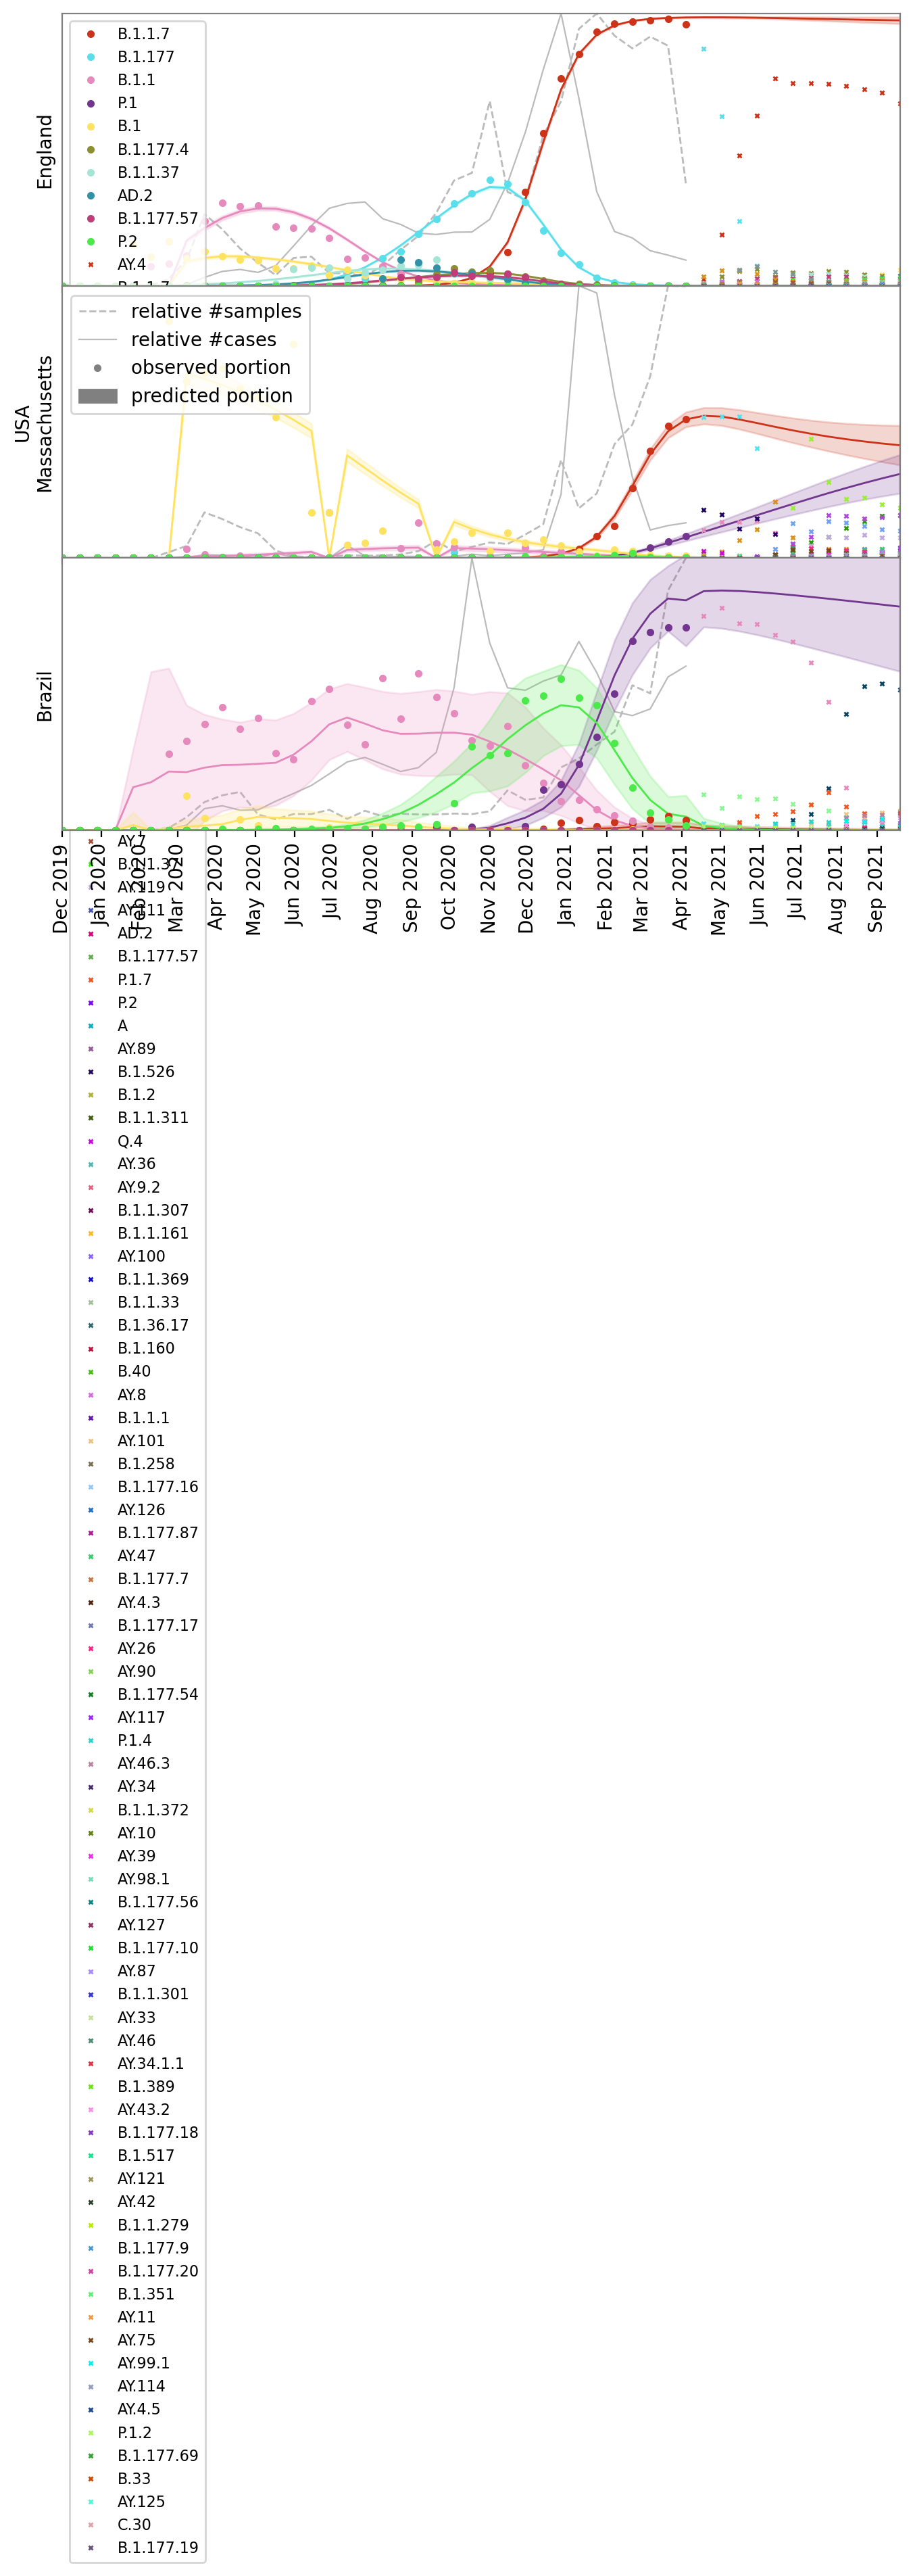

In [45]:
plot_forecast2(
    fit_n, 
    input_dataset, 
    queries=["England", "USA / Massachusetts", "Brazil"],
    num_strains=10,
    verbose=True)

In [ ]:
import importlib

In [ ]:
plot_forecast(fits[list(fits.keys())[0]], input_dataset,
              queries=["England", "USA / Massachusetts", "Brazil"],
              num_strains=10)

In [ ]:
def plusminus(mean, std):
    """Helper function for generating 95% CIs as the first dim of a tenson"""
    p95 = 1.96 * std
    return torch.stack([mean - p95, mean, mean + p95])

In [ ]:
def fix_negative_index(i, dim_size):
    if i < 0:
        return dim_size + i
    else:
        return i

In [ ]:
def get_fit_predicted_observed_by_query(
    dataset,
    fit,
    queries = ["England","USA / California", "Brazil"],
    verbose = False,
):
    
    if isinstance(queries, str):
        logging.debug("queries was string, converting to array")
        queries = [queries]
    
    # OrderedDict([('Oceania / Australia', 0), ...
    # 826 entries
    location_id = fit["location_id"]
    
    # Tensor 11 x 826 (time_intervals x location)
    weekly_cases = fit["weekly_cases"]
    
    # These are the T x P x L shaped probabilities (e.g. [23,826,1482])
    probs_orig = fit["mean"]["probs"]
    if verbose:
        print(f'probs_orig shape: {probs_orig.shape}')
    
    # This is T x P x C shaped
    # get weekly_clades from dataset and truncate to the max predicted time
    
    # weekly_clades from the dataset
    weekly_clades = dataset["weekly_clades"]
    if verbose:
        print(f'weekly_clades shape from dataset: {weekly_clades.shape}')
        
    # TODO: subset weakly_clades from "dataset" to the places included in "fit"
    fit_location_id = fit['location_id']
    fit_location_names = [name for name, _ in fit_location_id.items()]
    
    assert len(set(fit_location_names)) == len(fit_location_names)
    
    dataset_location_id = dataset['location_id']
    dataset_location_names = [name for name, _ in dataset_location_id.items()]
    
    assert len(set(dataset_location_names)) == len(dataset_location_names)
    
    assert all([name in dataset_location_names for name in fit_location_names])
    dataset_location_name_to_index_map = {
        name: idx for idx, name in enumerate(dataset_location_names)}
    dataset_fit_location_subset_indices = list(
        map(dataset_location_name_to_index_map.get, fit_location_names))
    weekly_clades = weekly_clades[:, dataset_fit_location_subset_indices, :]
    
    # TODO: print the shape of weekly clades after subsetting 
    if verbose:
        print(f'weekly_clades shape after harmonizing with fit: {weekly_clades.shape}')
        
    # Subset weekly_clades dataset in time up to the last timepoint we predict
    # This is longer than the input dataset of the fit we are examining
    weekly_clades = torch.index_select(weekly_clades,0,torch.arange(start=0,end=probs_orig.shape[0]))
    
    if verbose:
        print(f'weekly_clades shape: {weekly_clades.shape}')
        print(f'weekly_clades dtype: {weekly_clades.dtype}')
    
    # Reducing clade counts to lineage counts
    clade_id_to_lineage_id = dataset['clade_id_to_lineage_id']
    L = len(dataset["lineage_id"])
    
    # T x P x L tensor
    weekly_lineages = weekly_clades.new_zeros(weekly_clades.shape[:2] + (L,)).scatter_add_(
        -1, clade_id_to_lineage_id.expand_as(weekly_clades), weekly_clades
    )
    
    # The difference between the two is the number of forecast steps
    forecast_steps = probs_orig.shape[0] - fit["weekly_clades"].shape[0]
    
    # We now augment the probabilities with +/- 1 SD
    probs = plusminus(probs_orig, fit['std']['probs'])
    
    # Pad weekly_cases [11 x 826] with entries for the forecasting steps
    # using the last weekly_cases values
    padding = 1 + weekly_cases[-1:].expand(forecast_steps, -1)
    weekly_cases_padded = torch.cat([weekly_cases, padding], 0)
    
    # Weight weekly cases by strain probabilities
    # 3 x T x P x S
    predicted = probs * weekly_cases_padded[None, :, :, None]
    if verbose:
        print(f'predicted shape: {predicted.shape}')
    
    # Generate empty output predicted    
    output_shape =  (len(queries), 3, predicted.shape[-3]) + (predicted.shape[-1],)
    output_predicted = torch.zeros(output_shape) # Q x 3 x T x S
    
    # Generate empty output observed
    output_obseved_shape =  (len(queries), predicted.shape[-3]) + (predicted.shape[-1],)
    output_observed = torch.zeros(output_obseved_shape) # Q x T x S
    
    # For each query calculate the predicted values
    for k, query in enumerate(queries):
        # The indexes of all the places that match current query
        #place_dim_size = predicted.shape[-2]
        #place_ids = torch.tensor([fix_negative_index(i, place_dim_size) for name, i in location_id.items() if query in name])

        # Using position on the dict
        names = [ name for name, i in location_id.items() ]
        place_ids = [ i for i, name in enumerate(names) if name.find(query) != -1 ]
        if verbose:
            print(f'query: {query}, number of place ids: {len(place_ids)}')
        
        # Calculate predicted
        pred = predicted[:, :, place_ids, :].sum(-2)  # 3 x T x S
        if verbose:
            print(f'pred shape: {pred.shape}')
        #pred = predicted.index_select(-2, place_ids).sum(-2)
        
        # Sum over places and normalize to mean
        # pred[1] is the mean
        pred /= pred[1].sum(-1, keepdim=True).clamp_(min=1e-7)

        # Calculate observed
        obs = weekly_lineages[:, place_ids].sum(1)
        if verbose:
            print(f'obs shape: {obs.shape}')
        obs /= obs.sum(-1, keepdim=True).clamp_(min=1e-7)
        
        # Queries (3) x Stats(3) x Time(23) x Strains
        output_predicted[k] = pred
        
        # Queries (3) x Time(11) x Strains
        output_observed[k] = obs
    
    return {
        "predicted": output_predicted,
        "observed": output_observed,
        "queries": queries,
        "lineage_id": dataset['lineage_id'],
        "lineage_id_inv": dataset['lineage_id_inv']
    }

In [ ]:
def generate_strain_color_map_dict(strains, n_colors_distinct=20):
    n_colors = len(strains)
    n_color_black = n_colors - n_colors_distinct
    c_tmp = [f"C{i}" for i in range(n_colors)] + ["black"] * n_color_black
    color_map = {strains[i]: c_tmp[i] for i in range(len(strains))}
    return color_map

In [ ]:
def plot_predicted_observed(pred_data, 
                            strains_to_show = ['B.1.1.7','B.1.617.2','B.1.177'],
                            show_forecast = True,
                            show_observed = True,
                            colors = None,
                            filename = None
                           ):
    """ 
    Plot predicted and observed data for a specific fit
    
    :param pred_data: predicted and observed data calculations generated by get_fit_predicted_observed_by_query()
    :param strains_to_show: strains to plot
    :param show_forecast: plot model strain fit
    :param show_observed: show the observed points   
    :param filename: optional filename to save plot
    """
    predicted = pred_data['predicted']
    observed = pred_data['observed']
    queries = pred_data['queries']
    
    dates = matplotlib.dates.date2num(mutrans.date_range(predicted.shape[2]))
   
    # dictionary "A.1": 1
    strain_ids = pred_data['lineage_id']
    
    n_queries = len(queries)
    
    fig, ax = plt.subplots(nrows=n_queries, sharex=True)
    if not isinstance(ax, (list, np.ndarray)):
        ax = [ax]
        
    if colors is None:
        colors = generate_strain_color_map_dict(strains_to_show)
    
    for k, (ax_c, query) in enumerate(zip(ax, queries)):
        sel_forecast = predicted[k, 1, :]
        sel_forecast_lb = predicted[k, 0, :]
        sel_forecast_ub = predicted[k, 2, :]
        
        sel_observed = observed[k, :]
        
        #ax_c.set_ylim(0, 1)
        ax_c.set_yticks(())
        ax_c.set_ylabel(query.replace(" / ", "\n"))
        ax_c.set_xlim(dates.min(), dates.max())
        
        for s in strain_ids:
            
            strain_id = strain_ids[s]
            if s in strains_to_show:
                color = colors[s]
                if show_forecast:
                    ax_c.fill_between(
                        dates[: len(sel_forecast)],
                        sel_forecast_lb[: len(sel_forecast), strain_id],
                        sel_forecast_ub[: len(sel_forecast), strain_id],
                        color=color,
                        alpha=0.2,
                        zorder=-10,
                    )
                    ax_c.plot(
                        dates[: len(sel_forecast)],
                        sel_forecast[:, strain_id],
                        label=s,
                        color=color,
                    )
                if show_observed:
                    # TODO: Add future points that are not used with different marker
                    ax_c.plot(
                        dates[: len(sel_observed)],
                        sel_observed[:, strain_id],
                        lw=0,
                        marker="o",
                        color=color,
                    )
        if k == 0:
            ax_c.legend(loc="upper left", fontsize=8)
    
    ax_c.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
    ax_c.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b %Y"))
    plt.subplots_adjust(hspace=0)

    plt.xticks(rotation=90)
    fig.show()
    
    if filename:
        plt.savefig(filename)
        
    return {"colors": colors}

fit_0['mean']['probs'].shape

len(fit_0['location_id'])

In [ ]:
first_index = 0
last_index = len(list(fits.keys())) - 1

fit_0 = fits[list(fits.keys())[last_index]]
z = get_fit_predicted_observed_by_query(input_dataset, fit_0, verbose = True,
                                        queries = ["England","USA / Massachusetts", "Brazil"])


In [ ]:
matplotlib.rcParams['figure.figsize'] = [10,12]

In [ ]:
l = plot_predicted_observed(z, strains_to_show = ['B.1.1.7','B.1.617.2','B.1.177','P.1',
                                                  'B.1.1','B.1','B.1.177.4','B.1.1.37','AD.2','B.1.177.57'],)

In [ ]:
for name, _ in fit_0['location_id'].items():
    if name.find('Brit') != -1:
        print(name)

In [ ]:
importlib.reload(mutrans_helpers)

i = len(fits) - 1
key, latest_fit = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

strains_from_manuscript_figure = ['B.1.1.7','B.1.617.2','B.1.177','B.1.429','P.1',
                                 'B.1.1','B.1','B.1.427','B.1.2','B.1.177.4']


matplotlib.rcParams['figure.figsize'] = [10, 4]
plot_return = mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit, 
    strains_to_show=strains_from_manuscript_figure,
    queries=['England'],
    filename="paper/forecasts/forecast_day_542.png"
)

# Day 514: B.1.617.2 in UK

In [ ]:
i = 26
key, fit_d514 = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

strains_from_manuscript_figure = ['B.1.177.4','B.1.1','B.1.177', 'B.1.617.2','B.1','B.1.1.7']

matplotlib.rcParams['figure.figsize'] = [10, 4]
england_day_514_plot_return = mutrans_helpers.plot_fit_forecasts(
    fit=fit_d514, 
    strains_to_show=strains_from_manuscript_figure,
    queries=['England'],
    future_fit=latest_fit,
    filename='paper/forecasts/forecast_day_514.png',
    forecast_periods_plot=2,
)

In [ ]:
mutrans_helpers.evaluate_fit_forecast(fit_d514, latest_fit)

In [ ]:
evaluations = [(k,mutrans_helpers.evaluate_fit_forecast(f, latest_fit)) for k,f in fits.items()]

In [ ]:
x = np.linspace(0.0, 1.0, len(evaluations)+1)

In [ ]:
cmap = matplotlib.cm.get_cmap('rainbow')

In [ ]:
nValues = [k[8] for k,v in evaluations]
nValues = np.array(nValues)

In [ ]:
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.jet

In [ ]:
for i,(k,v) in enumerate(evaluations):
    model_days = k[8]
    kl = v['kl']
    plt.plot(kl, color=colormap(normalize(model_days)))

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nValues)
plt.colorbar(scalarmappaple, label='Max training day of model')

plt.xlim(0, 11)

plt.xticks([0, 2, 4, 6, 8, 10], labels=["0", "4", "8", "12", "16", "20"])

plt.xlabel('Forecasted weeks ahead')
plt.ylabel('KL Divergence (nats)')

#plt.show()

plt.savefig('paper/forecasts/kl_by_time.png')

In [ ]:
# Alternative representation of KL divergence

start_days = []
forecast_days = []
kl = []

for i,(k,v) in enumerate(evaluations):
    start_days_c = k[8]
    kl_vals = v['kl']
    for j, p in enumerate(kl_vals):
        start_days.append(start_days_c)
        forecast_days.append(j)
        kl.append(p.numpy().item())

df1 = pd.DataFrame({"start":start_days,"forecast":forecast_days,"kl":kl}).pivot(index='start', columns='forecast')

In [ ]:
# generate heatmap
sns.heatmap(df1.T.to_numpy())

In [ ]:
# MAE

In [ ]:
evaluations = [(k,mutrans_helpers.evaluate_fit_forecast(f, latest_fit)) for k,f in fits.items()]

In [ ]:
# 

In [ ]:
for i,(k,v) in enumerate(evaluations):
    model_days = k[8]
    mae = v['mae']
    plt.plot(mae, color=colormap(normalize(model_days)))

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nValues)
plt.colorbar(scalarmappaple, label='Max training day of model')

plt.xlim(0, 11)

plt.xticks([0, 2, 4, 6, 8, 10], labels=["0", "4", "8", "12", "16", "20"])

plt.xlabel('Forecasted weeks ahead')
plt.ylabel('Mean Absolute Error')

plt.show()

In [ ]:
evaluations = [(k,mutrans_helpers.evaluate_fit_forecast(f, latest_fit)) for k,f in fits.items()]

In [ ]:
# Wasserstein distance

for i,(k,v) in enumerate(evaluations):
    model_days = k[8]
    mae = v['wasserstein']
    plt.plot(mae, color=colormap(normalize(model_days)))

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nValues)
plt.colorbar(scalarmappaple, label='Max training day of model')

plt.xlim(0, 11)

plt.xticks([0, 2, 4, 6, 8, 10], labels=["0", "4", "8", "12", "16", "20"])

plt.xlabel('Forecasted weeks ahead')
plt.ylabel('Wasserstein')

plt.show()

## Why is USA / California total sum going to zero at the end?

In [ ]:
i = len(fits) - 1
key, latest_fit = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

strains_from_manuscript_figure = ['AY.2','B.1.1.7','B.1.617.2','B.1.177','B.1.429','P.1']

matplotlib.rcParams['figure.figsize'] = [10, 4]
z = mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit, 
    strains_to_show=strains_from_manuscript_figure,
    queries=['USA / California'],
)

## CA latest

In [ ]:
def get_region_names(fit):
    return fit['location_id']

In [ ]:
def find_prevalent_strains(fit, region, n=20):
    """Given a fit and region finds top n strains"""
    assert fit is not None
    assert region is not None
    
    fc0 = mutrans_helpers.generate_forecast(fit)
    
    region_index = fc0['location_id'][region]
    vals, indx = fit['mean']['probs'].max(0)
    so = vals[region_index,].sort(descending=True).indices[0:n].numpy()
    s0 = np.array(fit['lineage_id_inv'])[so].tolist()
    
    return s0
    

In [ ]:
def find_prevalent_strains(fit, query, n=20):
    """Given a fit and region finds top n strains"""
    assert fit is not None
    assert query is not None
    
    fc0 = mutrans_helpers.generate_forecast(fit)
    
    
    location_id = fc0['location_id']
    
    
    ids = torch.tensor([i for name, i in location_id.items() if query in name])
    
    #region_index = fc0['location_id'][region]
    
    vals, indx = fit['mean']['probs'].index_select(-2, ids).sum(-2).max(0)
    
    #so = vals[region_index,].sort(descending=True).indices[0:n].numpy()
    so = vals.sort(descending=True).indices[0:n].numpy()
    s0 = np.array(fit['lineage_id_inv'])[so].tolist()
    
    return s0

In [ ]:
ca_top_strains = find_prevalent_strains(latest_fit, 'North America / USA / California')

In [ ]:
ca_top_strains

## North America / USA / California

In [ ]:
ca_top_strains = find_prevalent_strains(latest_fit, 'North America / USA / California')

In [ ]:
z = mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=ca_top_strains,
    queries=['North America / USA / California'],
    filename="paper/per_region_forecasts/california.png"
)

## North America / USA / New York

In [ ]:
ny_top_strains = find_prevalent_strains(latest_fit, 'North America / USA / New York')

In [ ]:
z = mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=ny_top_strains,
    queries='North America / USA / New York',
    filename="paper/per_region_forecasts/new_york.png")

## Europe / United Kingdom / England

In [ ]:
region = 'Europe / United Kingdom / England'
ny_top_strains = find_prevalent_strains(latest_fit, region)
z = mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=ny_top_strains,
    queries=region,
    filename="paper/per_region_forecasts/uk_england.png")

## North America / USA

In [ ]:
region = 'North America / USA'
ny_top_strains = find_prevalent_strains(latest_fit, region,n=7)
z = mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=ny_top_strains,
    queries=region,
    filename="paper/per_region_forecasts/USA.png")

## Europe, Africa and Asia Plot preparation

In [ ]:
top_strains_europe =find_prevalent_strains(latest_fit, 'Europe',n=5)
top_strains_africa = find_prevalent_strains(latest_fit, 'Africa',n=5)
top_strains_asia = find_prevalent_strains(latest_fit, 'Asia',n=5)

In [ ]:
top_strains = list(set(top_strains_europe + top_strains_africa + top_strains_asia))

In [ ]:
len(top_strains)

# Europe

In [ ]:
region = 'Europe'
#top_strains = find_prevalent_strains(latest_fit, region,n=7)
z = mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=top_strains,
    queries=region,
filename="paper/per_region_forecasts/europe.png")

# Asia

In [ ]:
region = 'Asia'
#top_strains = find_prevalent_strains(latest_fit, region,n=7)
z = mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=top_strains,
    queries=region,
    filename="paper/per_region_forecasts/asia.png",
    colors=z['colors'])

# Africa

In [ ]:
region = 'Africa'
#top_strains = find_prevalent_strains(latest_fit, region,n=7)
z = mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=top_strains,
    queries=region,
    filename="paper/per_region_forecasts/africa_latest.png",
    colors=z['colors'])

## Day 346:  B.1.1.7 in UK

In [ ]:
plot_return.keys()

In [ ]:
importlib.reload(mutrans_helpers)

i = 14
key, fit_d346 = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

#strains_from_manuscript_figure = ['B.1.1.7','B.1.617.2','B.1.177','B.1.429','P.1',
#                                 'B.1.1','B.1','B.1.427','B.1.2','B.1.177.4']

strains_from_manuscript_figure = ['B.1.177.4','B.1.1','B.1.177', 'B.1.617.2','B.1','B.1.1.7']


matplotlib.rcParams['figure.figsize'] = [10, 4]
z = mutrans_helpers.plot_fit_forecasts(
    fit=fit_d346, 
    strains_to_show=strains_from_manuscript_figure,queries=['England'],
    future_fit=latest_fit,
    filename="paper/forecasts/forecast_day_346.png",
    colors=england_day_514_plot_return['colors']
)

In [ ]:
q = {"England": ['B.1','B.1.1.7','B.1.177','B.1.177.4']}

fit_eval_d346 = mutrans_helpers.evaluate_fit_forecast(fit_d346, latest_fit)

In [ ]:
# Plot MAE
plt.plot(fit_eval_d346['mae'])
plt.ylim(0, None)
plt.ylabel("MAE")
plt.xlabel("Time into future");

In [ ]:
# Plot KL
plt.plot(fit_eval_d346['kl'])
plt.ylim(0, None)
plt.ylabel("KL divergence")
plt.xlabel("Time into future");

In [ ]:
# Entropy
if False:
    plt.plot(-fit_eval_d346['log_likelihood'], "r-");
    plt.plot(fit_eval_d346['entropy'], "k--");
    plt.plot(fit_eval_d346['kl'], "g--");

In [ ]:
if False:
    plt.plot(fit_eval_d346['log_likelihood'].exp(), "r-");
    plt.plot((-fit_eval_d346['entropy']).exp(), "k--");

In [ ]:
def get_prediction_match(fit, query, future_fit, periods_into_future=4):
    forecast = mutrans_helpers.generate_forecast(fit=fit, queries=[query],future_fit=future_fit)
    forecast_values = mutrans_helpers.get_forecast_values(forecast=forecast)

    lineage_id_inv = forecast_values["lineage_id_inv"]

    last_observed_period = forecast_values['observed'].shape[1] - 1
    last_available_period = forecast_values['predicted'].shape[2]

    match_count = 0
    total_count = 0
    
    
    for i in range(last_observed_period, last_observed_period+periods_into_future):
        predicted_strain = lineage_id_inv[np.argmax(forecast_values['predicted'][0,0,i,:])]
        actual_strain = lineage_id_inv[np.argmax(forecast_values['observed_future'][0,i,:])]
        total_count += 1
        if predicted_strain == actual_strain:
            match_count += 1
        
    return {
        'match_count': match_count,
        'total_count': total_count,
    }

In [ ]:
def get_frac_pred_match_for_region(region, first_model_index = 0, periods_into_future=4):
    keys = fits.keys()
    frac_match_vals = []
    for j in range(first_model_index, len(keys)-12):
        key, fit_eval = mutrans_helpers.get_fit_by_index(fits, j)
        pred_match = get_prediction_match(fit_eval, region, latest_fit, periods_into_future=periods_into_future)
        frac_match = pred_match['match_count'] / pred_match['total_count']
        frac_match_vals.append(frac_match)
    return np.mean(frac_match_vals)

In [ ]:
logging.getLogger().setLevel(logging.ERROR)

In [ ]:
get_frac_pred_match_for_region('USA',periods_into_future=4)

In [ ]:
get_frac_pred_match_for_region('USA',periods_into_future=8)

In [ ]:
get_frac_pred_match_for_region('France',periods_into_future=4)

In [ ]:
get_frac_pred_match_for_region('France',periods_into_future=8)

In [ ]:
get_frac_pred_match_for_region('England',periods_into_future=4)

In [ ]:
get_frac_pred_match_for_region('England',periods_into_future=8)

In [ ]:
get_frac_pred_match_for_region('Brazil',periods_into_future=4)

In [ ]:
get_frac_pred_match_for_region('Brazil',periods_into_future=8)

In [ ]:
get_frac_pred_match_for_region('Australia',periods_into_future=4)

In [ ]:
get_frac_pred_match_for_region('Australia',periods_into_future=8)

In [ ]:
get_frac_pred_match_for_region('Russia',periods_into_future=4)

In [ ]:
get_frac_pred_match_for_region('Russia',periods_into_future=8)

In [ ]:
get_frac_pred_match_for_region('Denmark',periods_into_future=4)

In [ ]:
get_frac_pred_match_for_region('Denmark',periods_into_future=8)

In [ ]:
get_frac_pred_match_for_region('India',periods_into_future=4)

In [ ]:
get_frac_pred_match_for_region('India',periods_into_future=8)

In [ ]:
i = 0
key, fit_d346 = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

#strains_from_manuscript_figure = ['B.1.1.7','B.1.617.2','B.1.177','B.1.429','P.1',
#                                 'B.1.1','B.1','B.1.427','B.1.2','B.1.177.4']

strains_from_manuscript_figure = ['B.1.177.4','B.1.1','B.1.177', 'B.1.617.2','B.1','B.1.1.7']


matplotlib.rcParams['figure.figsize'] = [10, 4]
z = mutrans_helpers.plot_fit_forecasts(
    fit=fit_d346, 
    strains_to_show=strains_from_manuscript_figure,queries=['India'],
    future_fit=latest_fit,
    colors=england_day_514_plot_return['colors']
)

In [ ]:
def day_to_date(day):
    period = math.ceil(day/14)
    return mutrans.date_range(period)[-1].strftime("%d/%m/%y")

In [ ]:
day_to_date(150)